### Importação das Bibliotecas

In [1]:
# Tratamento dos dados
import pandas as pd
import numpy as np

# Visualização de Dados
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose

# Ciência de Dados
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

# Biblioteca do Prophet - Modelo de Projeção
from prophet import Prophet
from prophet.plot import plot, plot_plotly, plot_components_plotly, add_changepoints_to_plot
from prophet.plot import add_changepoints_to_plot, plot_seasonality, plot_cross_validation_metric
from prophet.diagnostics import cross_validation

### Importação e Descrição dos Dados

Essa é a parte 2 de um projeto que busca prever as vendas de uma padaria francesa.

Para uma melhor compreensão do cenário, caso ainda não tenha acompanhado, recomenda-se ler o notebook ```bakery_sales_data_analysis.ipynb``` previamente.

Neste notebook são explorados diferentes modelos de Machine Learning para séries temporais, são eles:
- Prophet
- XGBoost
- LightGBM



In [3]:
df = pd.read_csv('bakery_sales.csv', index_col=0)

# Update datatypes and data processing
df['date'] = pd.to_datetime(df['date'])
df['time'] = pd.to_datetime(df['time'], format='%H:%M').dt.time

df['Quantity'] = df['Quantity'].apply(lambda x: abs(int(x)))
df['Quantity'] = df['Quantity'].astype(int)

df['unit_price'] = df['unit_price'].str[:-2]
df['unit_price'] = df['unit_price'].str.replace(",",".")
df['unit_price'] = df['unit_price'].astype(float)

df['ticket_number'] = df['ticket_number'].astype(int)

# Cria coluna do total da compra
df['total_bill'] = df['Quantity'] * df['unit_price']

# Como nesse momento não será feita uma análise por produto, a coluna sera dropada
df.rename(columns={'Quantity':'quantity'}, inplace=True)
df_backup = df.copy()
df.drop(columns=['article', 'unit_price'], inplace=True)
df.head()

,date,time,ticket_number,quantity,total_bill
0,2021-01-02,08:38:00,150040,1,0.90
1,2021-01-02,08:38:00,150040,3,3.60
4,2021-01-02,09:14:00,150041,2,2.40
5,2021-01-02,09:14:00,150041,1,1.15
8,2021-01-02,09:25:00,150042,5,6.00


In [4]:
# Agrupa os dados por ticket (nota fiscal)
df_grouped = df.groupby(by=('ticket_number')).agg({'date':'first',
                                                   'time':'first',
                                                   'quantity':'sum',
                                                   'total_bill':'sum'})

df_grouped.reset_index(inplace=True)

df_grouped.head()

,ticket_number,date,time,quantity,total_bill
0,150040,2021-01-02,08:38:00,4,4.50
1,150041,2021-01-02,09:14:00,3,3.55
2,150042,2021-01-02,09:25:00,5,6.00
3,150043,2021-01-02,09:25:00,5,5.10
4,150044,2021-01-02,09:27:00,1,1.05


In [5]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136451 entries, 0 to 136450
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ticket_number  136451 non-null  int32         
 1   date           136451 non-null  datetime64[ns]
 2   time           136451 non-null  object        
 3   quantity       136451 non-null  int32         
 4   total_bill     136451 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int32(2), object(1)
memory usage: 4.2+ MB


#### Novas Features

In [6]:
# Novas Variaves, para analise
df = df_grouped.copy()

df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['day'] = df.date.dt.day
df['day_week'] = df.date.dt.day_of_week
df['hour'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.hour

# Cria um dataset com dados diarios
df_daily = df_grouped[['date', 'quantity', 'total_bill']].groupby('date').sum().reset_index()

df_daily['year'] = df_daily.date.dt.year
df_daily['month'] = df_daily.date.dt.month
df_daily['day'] = df_daily.date.dt.day
df_daily['day_week'] = df_daily.date.dt.day_of_week

df.head()

,ticket_number,date,time,quantity,total_bill,year,month,day,day_week,hour
0,150040,2021-01-02,08:38:00,4,4.50,2021,1,2,5,8
1,150041,2021-01-02,09:14:00,3,3.55,2021,1,2,5,9
2,150042,2021-01-02,09:25:00,5,6.00,2021,1,2,5,9
3,150043,2021-01-02,09:25:00,5,5.10,2021,1,2,5,9
4,150044,2021-01-02,09:27:00,1,1.05,2021,1,2,5,9


### Previsão com Prophet

O Prophet é um modelo de regressão desenvolvido pela Meta (Facebook) para previsão de séries temporais. 

É um modelo considerado robusto mas também fácil de usar. Costuma lidar bem com dados irregulares e valores ausentes. Um ponto interessante, é que esse modelo pode incorporar efeitos sazonais (semanal, mensal, anual ou personalizado), além de feriados para melhorar as previsões. Entretanto, ele pode ser menos preciso para séries temporais mais complexas e requer ajuste manual de parâmetros para melhores resultados.

In [50]:
# Cria base para usar no modelo
base = df_daily[['date','total_bill']].copy()
base.rename(columns={'total_bill':'y', 'date':'ds'}, inplace=True)

base.head(2)

,ds,y
0,2021-01-02,987.85
1,2021-01-03,1016.10


In [51]:
# Cria uma base temporária, na qual pode ser adicionada novas colunas e manipulação,
# a fim de rodar testes e análises
base_temp = base.copy()
base_temp['day_week'] = base_temp['ds'].dt.day_of_week

base_temp.loc[base_temp.day_week == 2].head()

,ds,y,day_week
88,2021-04-14,546.40,2
95,2021-04-21,623.25,2
102,2021-04-28,633.10,2
109,2021-05-05,777.80,2
116,2021-05-12,984.50,2


**Observação:** Até o metade de Abril de 2021 a loja não abria às quartas-feiras, tal informação pode ser relevante para analisar o desempenho do modelo nesse período.

#### O modelo

In [52]:
# Cria uma função que valida período de verão
# Como o comportamento nos meses de Julho e Agosto (verão na França) são diferentes dos demais meses, é criado um sinalizador
# para esse período, futuramente criando uma sazonalidade específica para esse período, de modo que o modelo
# compreenda e se ajuste melhor a diferença de comportamento destes meses
def summer(date):
    date - pd.to_datetime(date)
    return ((date.month == 7 and date.day >= 1) or (date.month == 9 and date.day <= 10))

# Aplica verificação na base de dados
base = df_daily[['date','total_bill']].copy()
base.rename(columns={'total_bill':'y', 'date':'ds'}, inplace=True)

base['summer'] = base['ds'].apply(summer)
#base['not_summer'] = ~base['ds'].apply(summer)

base.head()

,ds,y,summer
0,2021-01-02,987.85,False
1,2021-01-03,1016.10,False
2,2021-01-04,461.90,False
3,2021-01-05,536.50,False
4,2021-01-07,544.00,False


In [53]:
# Adiciona dados de verão na base_temp
base_temp['summer'] = base_temp.ds.apply(summer)
base_temp.head()

,ds,y,day_week,summer
0,2021-01-02,987.85,5,False
1,2021-01-03,1016.10,6,False
2,2021-01-04,461.90,0,False
3,2021-01-05,536.50,1,False
4,2021-01-07,544.00,3,False


In [36]:
# # Analise Comportamento Semanal no Verão
# base_temp = base.copy() 
# base['summer'] = base.ds.apply(summer)
# base['day_week'] = base.ds.dt.day_of_week

# fig = plt.subplots(1,2, figsize=(15,4))

# plt.subplot(1,2,1)
# ax = sns.lineplot(base_temp.loc[base.summer == True], x='day_week', y='y', estimator='mean')
# plt.title('Media Venda Mensal por Dia da Semana - Verão')
# plt.xlabel('')
# plt.ylabel('Sales (€)')


# plt.subplot(1,2,2)
# ax = sns.lineplot(base_temp.loc[base.summer == False], x='day_week', y='y', estimator='mean')
# plt.title('Media Venda Mensal por Dia da Semana - Fora de Verão')
# plt.xlabel('')
# plt.ylabel('Sales (€)')

# plt.suptitle('Analise Comportamento Semanal')

In [54]:
# Cria função que calcula o MAPE
def calculate_mape(y_true, y_pred):
    """
    Calcula Mean Absolute Percentage Error (MAPE) - Erro Percentual Absoluto Médio.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    # Avoid division by zero
    mask = y_true != 0
    mask_nan = pd.notna(y_true)
    y_true, y_pred = y_true[mask_nan], y_pred[mask_nan]

    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return mape

In [55]:
# Cria base de dados de feriados para serem inseridos no modelo posteriormente
holidays_info = pd.DataFrame({
  'holiday': 'holiday',                                           
  'ds': pd.to_datetime(['2021-01-02', '2022-01-02', '2022-01-02',  # New Year's
                        '2021-02-28', '2022-02-27', # Need furher explorations
                        '2021-04-04', '2022-04-17', '2023-04-09', # Easter Sunday
                        '2021-05-01', '2022-05-01', '2023-05-01', # Labor Day'
                        '2021-05-13', '2022-05-26', '2023-05-18', # Ascension Day I
                        '2021-05-14', '2022-05-27', '2023-05-19', # Ascension Day II
                        '2021-05-15', '2022-05-28', '2023-05-20', # Ascension Day III
                        '2021-05-16', '2022-05-29', '2023-05-21', # Ascension Day IV
                        '2021-05-23', '2022-06-05', '2023-05-28', # Whit Sunday
                        '2021-05-24', '2022-06-06', '2023-05-29', # Whit Monday
                        '2021-06-20', '2022-06-19', '2023-05-29', # Fathers Day
                        '2021-07-14', '2022-07-14', '2023-07-14', # Bastille Day
                        '2021-08-15', '2022-08-15', '2023-08-15', # Assumption Day
                        '2021-10-31', '2022-10-31', '2023-10-31', # Clock change
                        '2021-11-01', '2022-11-01', '2023-11-01', # All Saints' Day
                        '2021-12-24', '2022-12-24', '2023-12-24', # Christmas Eve
                        '2021-12-31', '2022-12-31', '2023-12-31', # Last Day
                        ]),
  'lower_window': -2,
  'upper_window': 2,
})

In [58]:
# Instancia o modelo e ajusta
model = Prophet(n_changepoints = 15, changepoint_prior_scale = 0.01,
                holidays = holidays_info, holidays_prior_scale=15.0,  
                seasonality_mode='additive')

# ADICIONAR FLAG É FIM DE SEMANA OU NÃO !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# Da pra fazer um versão do modelo pro produto mais vendido, no sentido de saber quantos preparar ? !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# model.add_seasonality(name='monthly', period=30.5, fourier_order=5) # não é utilizada pois pelas analises não há um padrão bem definido
model.add_seasonality(name='yearly', period=365, fourier_order=14)
model.add_seasonality(name='summer', period=70, fourier_order=3, condition_name='summer') 
# model.add_seasonality(name='week_not_summer', period=7, fourier_order=3, condition_name='not_summer')

model.fit(base)

future = model.make_future_dataframe(periods = 90, freq='D')
future['summer'] = future.ds.apply(summer)
# future['not_summer'] = future.ds.apply(summer)

predicted = model.predict(future)

# Calcula o MAPE
y_true = base.loc[base.ds >= '2022-09-01', 'y']
y_pred = predicted.loc[(predicted.ds >= '2022-09-01') & (predicted.ds <=  '2022-09-30'), 'yhat']
print(f"\nMAPE Sep/2022: {round(calculate_mape(y_true, y_pred),2)} %")

15:55:41 - cmdstanpy - INFO - Chain [1] start processing
15:55:41 - cmdstanpy - INFO - Chain [1] done processing



MAPE Sep/2022: 8.81 %


In [59]:
# Name change of pandas to avoid error
pd.DataFrame.iteritems = pd.DataFrame.items

# Exibe componentes identificados pelo modelo para gerar a predição
plot_components_plotly(model, predicted)

In [60]:
# Resumo dos valores preditos
plot_plotly(model, predicted)


MAPE Sep/2022: 8.81 %


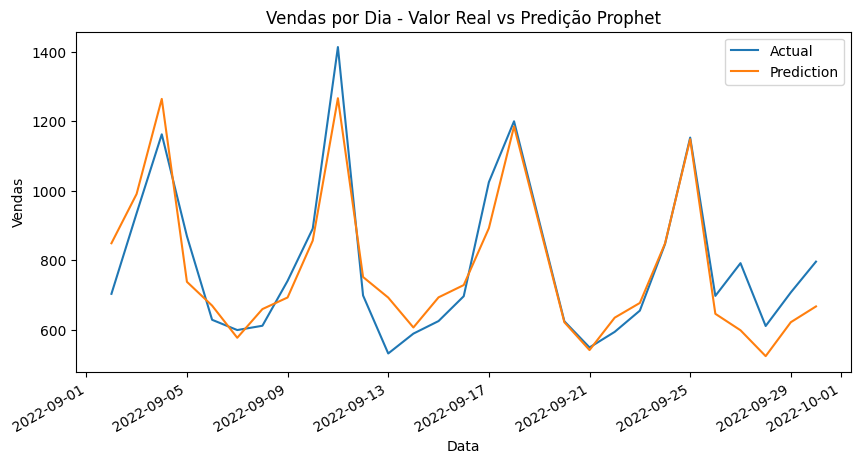

In [68]:
# Apresenta o MAPE e visualização dos dados
print(f"\nMAPE Sep/2022: {round(calculate_mape(y_true, y_pred),2)} %")

testing_dates = base.loc[base.ds >= '2022-09-01', 'ds']

df_test = pd.DataFrame({"date": testing_dates, "actual": y_true, "prediction": y_pred })

figure, ax = plt.subplots(figsize=(10, 5))
df_test.plot(ax=ax, label="Actual", x="date", y="actual")
df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
plt.legend(["Actual", "Prediction"])
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.title('Vendas por Dia - Valor Real vs Predição Prophet')
plt.show()

In [ ]:
# # Roda uma tunagem de hiperparametros

# # Tempo médio: 41minutos
# import itertools
# from prophet.diagnostics import performance_metrics

# param_grid = {  
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 3.0, 7.0],
#     'holidays_prior_scale': [0.01, 0.1, 1.0, 3.0, 7.0],
#     'seasonality_mode' : ['additive', 'multiplicative'],
#     'changepoint_range' : [0.75, 0.80, 0.85, 0.88, 0.92]
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# mape = []  # Store the mape for each params here

# cutoffs = pd.to_datetime(['2022-05-28', '2022-06-28', '2022-07-28'])

# # Use cross validation to evaluate all parameters
# for params in all_params:
#     model = Prophet(**params).fit(base)  # Fit model with given params
#     df_cv = cross_validation(model, cutoffs=cutoffs, horizon='30 days', parallel="processes")
#     df_p = performance_metrics(df_cv, rolling_window=1)
#     mape.append(df_p['mape'].values[0])

# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['mape'] = mape
# print(tuning_results)

# best_params = all_params[np.argmin(mape)]
# print(best_params)

Resultados: 

```{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}```

In [70]:
# Instancia o modelo e roda, com os melhores parametros
model_hyp = Prophet(n_changepoints = 25, changepoint_prior_scale = 0.1, changepoint_range = 0.8,
                holidays = holidays_info, holidays_prior_scale=0.01,  
                seasonality_mode='multiplicative')

model_hyp.add_seasonality(name='yearly', period=365, fourier_order=14)
model_hyp.add_seasonality(name='summer', period=70, fourier_order=3, condition_name='summer') 

model_hyp.fit(base)

future_hyp = model_hyp.make_future_dataframe(periods = 90, freq='D')
future_hyp['summer'] = future_hyp.ds.apply(summer)
# future_hyp['not_summer'] = future_hyp.ds.apply(summer)

predicted = model_hyp.predict(future_hyp)

y_true_hyp = base.loc[base.ds >= '2022-09-01', 'y']
y_pred_hyp = predicted.loc[(predicted.ds >= '2022-09-01') & (predicted.ds <=  '2022-09-30'), 'yhat']
print(f" MAPE Sep/2022: {round(calculate_mape(y_true_hyp, y_pred_hyp),2)} %")

16:03:13 - cmdstanpy - INFO - Chain [1] start processing
16:03:14 - cmdstanpy - INFO - Chain [1] done processing


 MAPE Sep/2022: 10.29 %



MAPE Sep/2022: 10.29 %


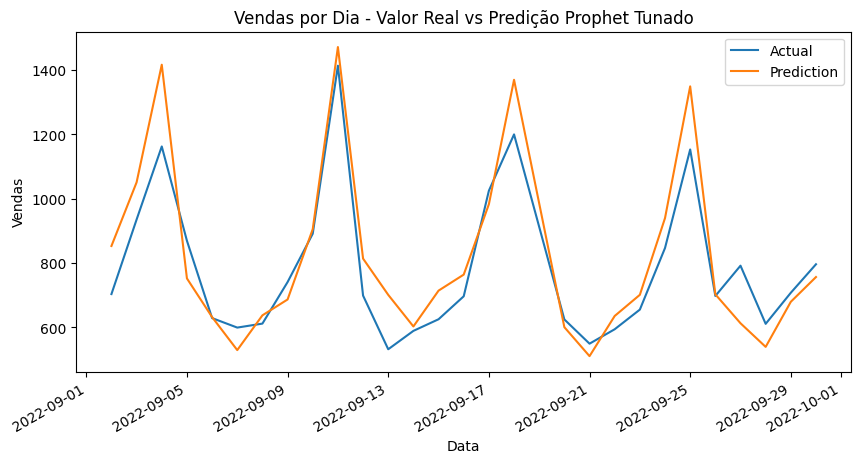

In [73]:
# Apresenta o MAPE e visualização dos dados
print(f"\nMAPE Sep/2022: {round(calculate_mape(y_true_hyp, y_pred_hyp),2)} %")

testing_dates = base.loc[base.ds >= '2022-09-01', 'ds']

df_test = pd.DataFrame({"date": testing_dates, "actual": y_true_hyp, "prediction": y_pred_hyp })

figure, ax = plt.subplots(figsize=(10, 5))
df_test.plot(ax=ax, label="Actual", x="date", y="actual")
df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
plt.legend(["Actual", "Prediction"])
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.title('Vendas por Dia - Valor Real vs Predição Prophet Tunado')
plt.show()

[[<matplotlib.lines.Line2D at 0x1a0c6b2eb10>]]

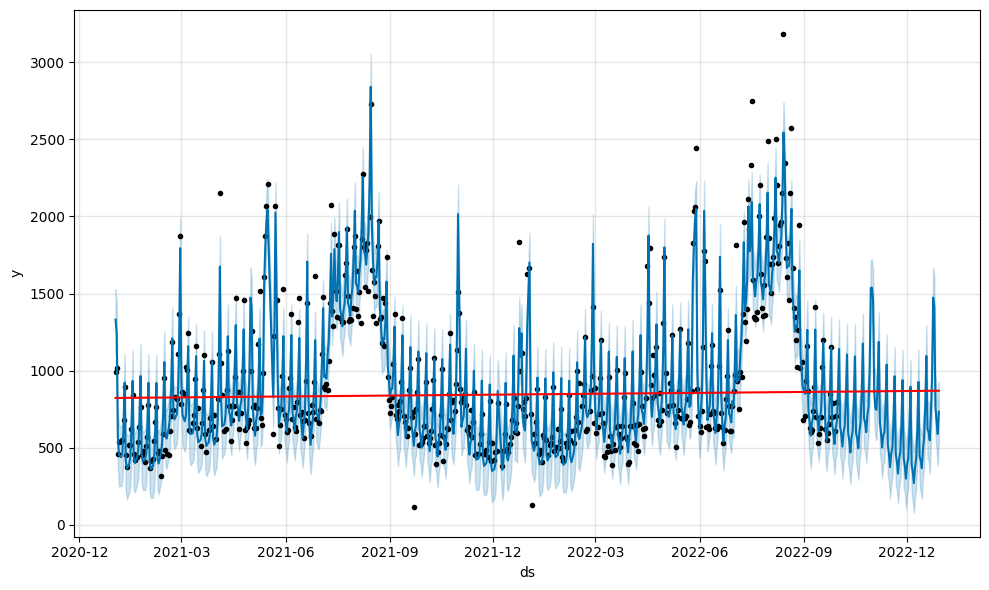

In [61]:
# Código utilizado para visualizar a posição dos changepoints apontados pelo modelo
# fig_changepoitns = model.plot(predicted) 
# add_changepoints_to_plot(fig_changepoitns.gca(), model, predicted)

### Previsão com LightGBM e XGBoost

Artigos de apoio:

[Artigo: Time Series Forecasting with XGBoost and LightGBM: Predicting Energy Consumption](https:/medium.com/@geokam/time-series-forecasting-with-xgboost-and-lightgbm-predicting-energy-consumption-460b675a9cee)

[Artigo: Time Series Forecasting with XGBoost and LightGBM: Predicting Energy Consumption with Lag Features](https://medium.com/@geokam/time-series-forecasting-with-xgboost-and-lightgbm-predicting-energy-consumption-with-lag-features-dbf69970a90f)

In [74]:
# Importação das Bibliotecas
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [75]:
# Base Inicial, cria coluna de dia que ainda não existia
df_backup['day'] = df_backup.date.dt.day
df_backup['month'] = df_backup.date.dt.month
df_backup['year'] = df_backup.date.dt.year

# Cria nova base com total de vendas e valor médio por item, por dia
base2 = df_backup[['year', 'month', 'day', 'total_bill']].groupby(['year', 'month', 'day']).agg({'total_bill':'sum'}).reset_index() # 'unit_price', & 'unit_price':'mean',

# Adição de novas features
base2['date'] = pd.to_datetime(base2['year'].astype(str) + '-' + base2['month'].astype(str) + '-' + base2['day'].astype(str))
base2["day_of_week"] = base2["date"].dt.dayofweek
base2["day_of_year"] = base2["date"].dt.dayofyear
base2["quarter"] = base2["date"].dt.quarter
base2.head()

,year,month,day,total_bill,date,day_of_week,day_of_year,quarter
0,2021,1,2,987.85,2021-01-02,5,2,1
1,2021,1,3,1016.10,2021-01-03,6,3,1
2,2021,1,4,461.90,2021-01-04,0,4,1
3,2021,1,5,536.50,2021-01-05,1,5,1
4,2021,1,7,544.00,2021-01-07,3,7,1


Dias na base de treino: 572
Dias na base de teste: 28


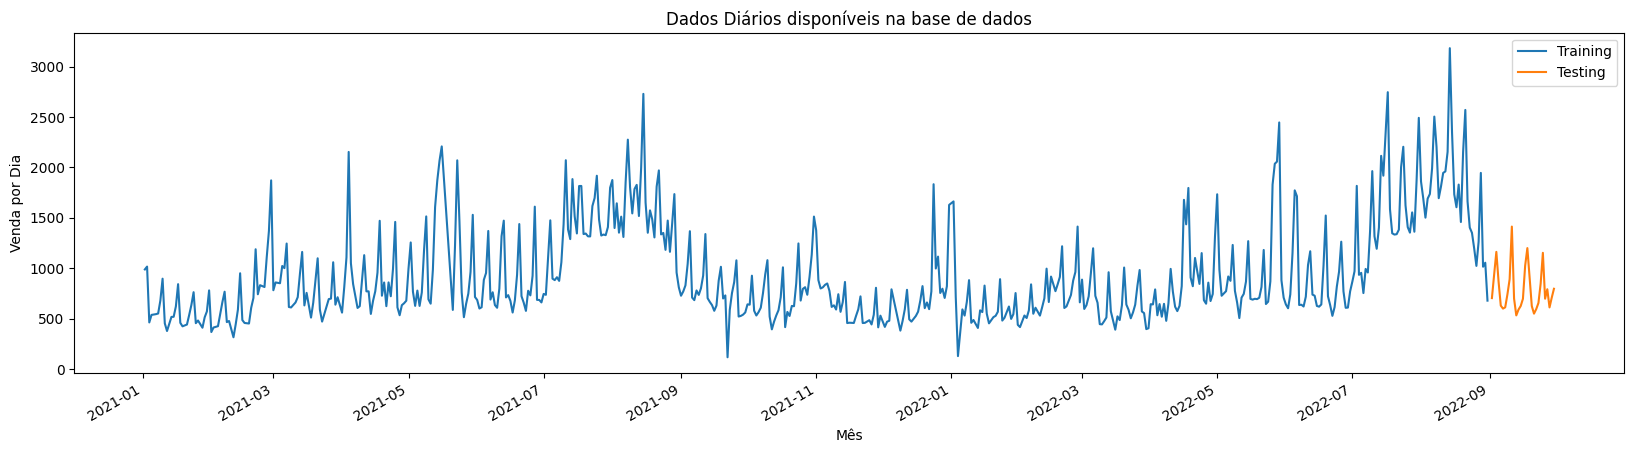

In [80]:
# Separa os dados em treino e teste
split_date = '2022-09-01'
training_data = base2.loc[base2["date"] < split_date]
print(f"Dias na base de treino: {training_data.shape[0]}")

testing_data = base2.loc[base2["date"] >= split_date]
print(f"Dias na base de teste: {testing_data.shape[0]}")

# Separa em features e target as bases de treino e teste
X_train = training_data[["day_of_week", "day_of_year", "month", "quarter", "year"]] # , "unit_price"
y_train = training_data["total_bill"]

X_test = testing_data[["day_of_week", "day_of_year", "month", "quarter", "year"]] #, "unit_price"
y_test = testing_data["total_bill"]

# Exibe em um gráfico os dados de treino e teste
figure, ax = plt.subplots(figsize=(20, 5))
training_data.plot(ax=ax, label="Training", x="date", y="total_bill")
testing_data.plot(ax=ax, label="Testing", x="date", y="total_bill")
plt.title('Dados Diários disponíveis na base de dados')
plt.xlabel('Mês')
plt.ylabel('Venda por Dia')
plt.show()

#### XGBoost

In [83]:
xgb_model = XGBRegressor()
parameters_xgb = {
    "max_depth": [3, 6, 9], # [3, 4, 6, 5, 10],
    "learning_rate": [0.01,  0.1, 0.3], # [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [100, 400, 750,  1000], # [100, 300, 500, 700, 900, 1000],
    "colsample_bytree":  [0.3, 0.5, 0.7] # [0.3, 0.5, 0.7]
}
cv_split = TimeSeriesSplit(n_splits=2, test_size=30)
grid_search_xgb = GridSearchCV(estimator=xgb_model, cv=cv_split, param_grid=parameters_xgb)
grid_search_xgb.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=30),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, impor...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7],
                         'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 6, 9],
                         'n_estimators': [100, 400, 750, 1000]})

#### LightGBM

In [ ]:
lgbm_model = lgb.LGBMRegressor()
parameters_lgbm = {
   "max_depth": [3, 4, 6, 5, 10], # [3, 6, 9], 
    "num_leaves": [10, 20, 30, 40, 100, 120], # [10, 40, 100],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3], # [0.01,  0.1, 0.3],
    "n_estimators": [100, 300, 500, 700, 900, 1000], # [100, 400, 750,  1000], 
    "colsample_bytree": [0.3, 0.5, 0.7] # [0.3, 0.5, 0.7]
}

grid_search_lgbm = GridSearchCV(estimator=lgbm_model, cv=cv_split, param_grid=parameters_lgbm)
grid_search_lgbm.fit(X_train, y_train)

In [ ]:
lgbm_model = lgb.LGBMRegressor()
parameters_lgbm = {
   "max_depth": [3, 6, 9],  
    "num_leaves": [10, 40, 100], 
    "learning_rate": [0.01,  0.1, 0.3], 
    "n_estimators": [100, 400, 750,  1000],  
    "colsample_bytree": [0.3, 0.5, 0.7] }

grid_search_lgbm = GridSearchCV(estimator=lgbm_model, cv=cv_split, param_grid=parameters_lgbm)
grid_search_lgbm.fit(X_train, y_train)

#### Resultados

In [85]:
# Cria funções que retornam as métricas e gráfico das predições
def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"MSE: {mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")

def plot_predictions(testing_dates, y_test, prediction, nome_modelo):
  df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
  figure, ax = plt.subplots(figsize=(10, 5))
  df_test.plot(ax=ax, label="Actual", x="date", y="actual")
  df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
  plt.legend(["Actual", "Prediction"])
  plt.xlabel('Data')
  plt.ylabel('Vendas')
  plt.title(f'Vendas por Dia - Valor Real vs Predição {nome_modelo}')
  plt.show()

# Extrai coluna com datas para plotagem do gráfico
testing_dates = df_daily.loc[df_daily.date >= split_date, 'date']

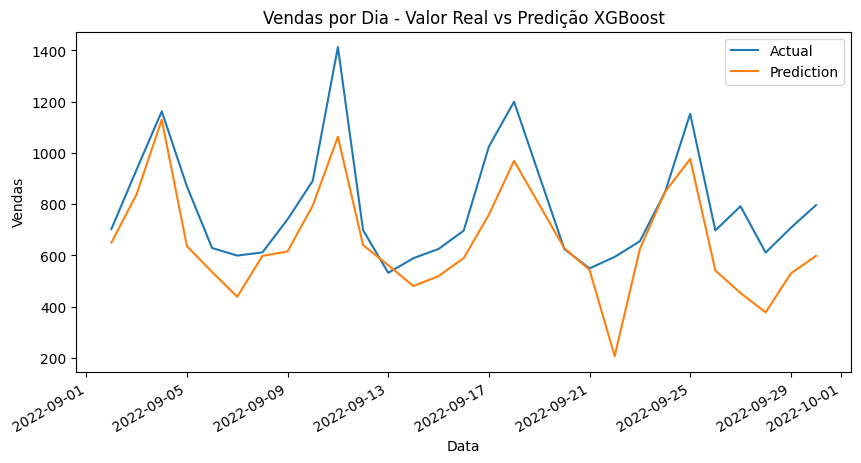

MAE: 138.29625353131976
MSE: 30710.662512350962
MAPE: 0.17660148756859043


In [86]:
# Resultados XGBoost
prediction_xgb = grid_search_xgb.predict(X_test)
plot_predictions(testing_dates, y_test, prediction_xgb, "XGBoost")

evaluate_model(y_test, prediction_xgb)

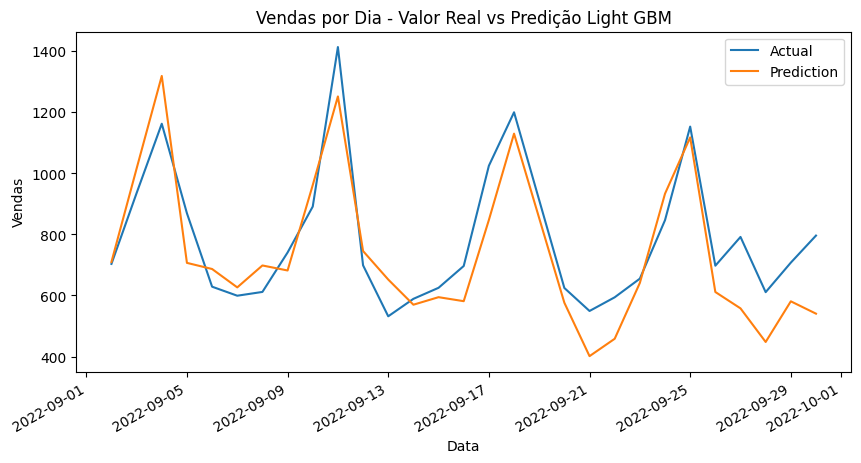

MAE: 99.3545174769023
MSE: 14036.85809907485
MAPE: 0.13062608794869346


In [88]:
# Resultados LightGBM
prediction_lgbm = grid_search_lgbm.predict(X_test)
plot_predictions(testing_dates, y_test, prediction_lgbm, 'Light GBM')
evaluate_model(y_test, prediction_lgbm)

In [ ]:
# # REVER
# # Plota feature importance do LGBM
# def plotImp(model, X , num = 20, fig_size = (40, 20)):
#     feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
#     plt.figure(figsize=fig_size)
#     sns.set(font_scale = 5)
#     sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
#                                                         ascending=False)[0:num])
#     plt.title('LightGBM Features')
#     plt.tight_layout()
#     plt.savefig('lgbm_importances-01.png')
#     plt.show()

# plotImp(model, X_valid)

### Resumo Projeto

**Desafios:**

- Base dados pequena, há meses que só há um ano de referência
- Pouco conhecimento local e do negócio
    - por não ser residente da França, alguns conhecimentos podem ter se ausentado, por não conhecer tão bem a cultura e comportamentos (exemplo: impacto dos feriados)
    - sem conhecimento real do negócio (exemplo: motivo pelo qual não abria quarta-feira, feriados locais)
- Escolha do modelo adequado para previsões, considerando a sazonalidade e tendências nos dados.

**Oportunidades:**

Além das mencionados ao longo do projeto, há outras possibilidades que podem ser exploradas:

- Expandir a análise para incluir tendências de vendas de produtos individuais.
- Estudar a correlação entre o preço dos produtos e as vendas.
- Utilizar dados externos, como clima ou eventos locais, para melhorar a precisão das previsões.
- Utilizar dados do negócio como valor médio por item, quantidade de itens no cardápio, lags de vendas nos dias anteriores.
- Uso de Deep Learning para predições.

**Aprendizados:**

- Melhoria nas habilidades de limpeza e preparação de dados, garantindo a precisão e a integridade dos dados analisados.
- Aperfeiçoamento das habilidades de análise, ao considerar diferentes cenários e observar comportamentos em diversos períodos (mês, ano, semana...). 
- Desenvolvimento de uma construção lógica para a exploração de dados e criação de visualizações que transmitem de forma eficaz as informações descobertas.
- Aprofundamento no uso dos modelos (Prophet, XGBoost, LightGBM) para previsões de séries temporais.
